# IEEE Fraud Detection Kaggle Competition

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

num_folds = 5
SEED = 5000

In [3]:
import random, os
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything()

In [4]:
sampled_train_original = pd.read_csv('../../output/sampled_train_reduced_mem.csv')

In [5]:
train = pd.read_csv('../../output/train_reduced_mem.csv')
test = pd.read_csv('../../output/test_reduced_mem.csv')

In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
# sampled_train_original = reduce_mem_usage(sampled_train_original)

In [8]:
params = {
                'objective':'binary',
                'boosting_type':'gbdt',
                'metric':'auc',
                'n_jobs':-1,
                'learning_rate':0.064,
                'num_leaves': 2**8,
                'max_depth':-1,
                'tree_learner':'serial',
                'colsample_bytree': 0.85,
                'subsample_freq':1,
                'subsample':0.85,
                'max_bin':255,
                'verbose':-1,
                'seed': SEED,
                'reg_alpha':0.3,
                'reg_lambda':0.243
            } 
# Uses a lower learning rate - default is 0.1. This is not changed in my notebooks, try again with this change?
# params['learning_rate'] = 0.005
params['learning_rate'] = 0.01
# params['n_estimators'] = 3000
params['n_estimators'] = 550
# params['early_stopping_rounds'] = 100    

In [9]:
sampled_train_original.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek
0,2996780,0,302413,25.98,C,4461,375.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,NaN,New,NotFound,225.0,NaN,266.0,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,F3213 Build/36.1.

In [10]:
n_days_in_week_21 = 18509

In [11]:
"""
This module provides a class to split time-series data for back-testing and evaluation.
The aim was to extend the current sklearn implementation and extend it's uses.

Might be useful for some ;)
"""

import logging
from typing import Optional

import numpy as np
from sklearn.model_selection._split import _BaseKFold
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples

LOGGER = logging.getLogger(__name__)


class TimeSeriesSplit(_BaseKFold):  # pylint: disable=abstract-method
    """Time Series cross-validator

    Provides train/test indices to split time series data samples that are observed at fixed time intervals,
    in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is
    inappropriate.

    This cross_validation object is a variation of :class:`TimeSeriesSplit` from the popular scikit-learn package.
    It extends its base functionality to allow for expanding windows, and rolling windows with configurable train and
    test sizes and delays between each. i.e. train on weeks 1-8, skip week 9, predict week 10-11.

    In this implementation we specifically force the test size to be equal across all splits.

    Expanding Window:

            Idx / Time  0..............................................n
            1           |  train  | delay |  test  |                   |
            2           |       train     | delay  |  test  |          |
            ...         |                                              |
            last        |            train            | delay |  test  |

    Rolling Windows:
            Idx / Time  0..............................................n
            1           | train   | delay |  test  |                   |
            2           | step |  train  | delay |  test  |            |
            ...         |                                              |
            last        | step | ... | step |  train  | delay |  test  |

    Parameters:
        n_splits : int, default=5
            Number of splits. Must be at least 4.

        train_size : int, optional
            Size for a single training set.

        test_size : int, optional, must be positive
            Size of a single testing set

        delay : int, default=0, must be positive
            Number of index shifts to make between train and test sets
            e.g,
            delay=0
                TRAIN: [0 1 2 3] TEST: [4]
            delay=1
                TRAIN: [0 1 2 3] TEST: [5]
            delay=2
                TRAIN: [0 1 2 3] TEST: [6]

        force_step_size : int, optional
            Ignore split logic and force the training data to shift by the step size forward for n_splits
            e.g
            TRAIN: [ 0  1  2  3] TEST: [4]
            TRAIN: [ 0  1  2  3  4] TEST: [5]
            TRAIN: [ 0  1  2  3  4  5] TEST: [6]
            TRAIN: [ 0  1  2  3  4  5  6] TEST: [7]

    Examples
    --------
    >>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
    >>> y = np.array([1, 2, 3, 4, 5, 6])
    >>> tscv = TimeSeriesSplit(n_splits=5)
    >>> print(tscv)  # doctest: +NORMALIZE_WHITESPACE
    TimeSeriesSplit(train_size=None, n_splits=5)
    >>> for train_index, test_index in tscv.split(X):
    ...    print('TRAIN:', train_index, 'TEST:', test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0] TEST: [1]
    TRAIN: [0 1] TEST: [2]
    TRAIN: [0 1 2] TEST: [3]
    TRAIN: [0 1 2 3] TEST: [4]
    TRAIN: [0 1 2 3 4] TEST: [5]
    """

    def __init__(self,
                 n_splits: Optional[int] = 5,
                 train_size: Optional[int] = None,
                 test_size: Optional[int] = None,
                 delay: int = 0,
                 force_step_size: Optional[int] = None):

        if n_splits and n_splits < 5:
            raise ValueError(f'Cannot have n_splits less than 5 (n_splits={n_splits})')
        super().__init__(n_splits, shuffle=False, random_state=None)

        self.train_size = train_size

        if test_size and test_size < 0:
            raise ValueError(f'Cannot have negative values of test_size (test_size={test_size})')
        self.test_size = test_size

        if delay < 0:
            raise ValueError(f'Cannot have negative values of delay (delay={delay})')
        self.delay = delay

        if force_step_size and force_step_size < 1:
            raise ValueError(f'Cannot have zero or negative values of force_step_size '
                             f'(force_step_size={force_step_size}).')

        self.force_step_size = force_step_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.

        Parameters:
            X : array-like, shape (n_samples, n_features)
                Training data, where n_samples is the number of samples  and n_features is the number of features.

            y : array-like, shape (n_samples,)
                Always ignored, exists for compatibility.

            groups : array-like, with shape (n_samples,), optional
                Always ignored, exists for compatibility.

        Yields:
            train : ndarray
                The training set indices for that split.

            test : ndarray
                The testing set indices for that split.
        """
        X, y, groups = indexable(X, y, groups)  # pylint: disable=unbalanced-tuple-unpacking
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        delay = self.delay

        if n_folds > n_samples:
            raise ValueError(f'Cannot have number of folds={n_folds} greater than the number of samples: {n_samples}.')

        indices = np.arange(n_samples)
        split_size = n_samples // n_folds

        train_size = self.train_size or split_size * self.n_splits
        test_size = self.test_size or n_samples // n_folds
        full_test = test_size + delay

        if full_test + n_splits > n_samples:
            raise ValueError(f'test_size\\({test_size}\\) + delay\\({delay}\\) = {test_size + delay} + '
                             f'n_splits={n_splits} \n'
                             f' greater than the number of samples: {n_samples}. Cannot create fold logic.')

        # Generate logic for splits.
        # Overwrite fold test_starts ranges if force_step_size is specified.
        if self.force_step_size:
            step_size = self.force_step_size
            final_fold_start = n_samples - (train_size + full_test)
            range_start = (final_fold_start % step_size) + train_size

            test_starts = range(range_start, n_samples, step_size)

        else:
            if not self.train_size:
                step_size = split_size
                range_start = (split_size - full_test) + split_size + (n_samples % n_folds)
            else:
                step_size = (n_samples - (train_size + full_test)) // n_folds
                final_fold_start = n_samples - (train_size + full_test)
                range_start = (final_fold_start - (step_size * (n_splits - 1))) + train_size

            test_starts = range(range_start, n_samples, step_size)

        # Generate data splits.
        for test_start in test_starts:
            idx_start = test_start - train_size if self.train_size is not None else 0
            # Ensure we always return a test set of the same size
            if indices[test_start:test_start + full_test].size < full_test:
                continue
            yield (indices[idx_start:test_start],
                   indices[test_start + delay:test_start + full_test])

In [39]:
def country_match(df):
    temp_df = df[['card3', 'addr2']]
    temp_df['country_match'] = np.nan
    temp_df['country_match'] = np.where((temp_df['card3'] == 150) & (temp_df['addr2'] == 87),
                                        1,
                                        temp_df['country_match'])

    temp_df['country_match'] = np.where((temp_df['card3'] == 150) & (temp_df['addr2'] != 87),
                                        1,
                                        temp_df['country_match'])

    temp_df['country_match'] = np.where((temp_df['card3'] != 150) & (temp_df['addr2'] == 87),
                                        1,
                                        temp_df['country_match'])

    temp_df['country_match'] = np.where((temp_df['card3'] == 185) & (temp_df['addr2'] == 60),
                                        1,
                                        temp_df['country_match'])

    temp_df['country_match'] = np.where((temp_df['card3'] == 185) & (temp_df['addr2'] != 60),
                                        0,
                                        temp_df['country_match'])

    temp_df['country_match'] = np.where((temp_df['card3'] != 185) & (temp_df['addr2'] == 60),
                                        0,
                                        temp_df['country_match'])

    temp_df['country_match'] = np.where((temp_df['card3'] == 144) & (temp_df['addr2'] == 96),
                                        1,
                                        temp_df['country_match'])

    temp_df['country_match'] = np.where((temp_df['card3'] == 144) & (temp_df['addr2'] != 96),
                                        0,
                                        temp_df['country_match'])

    temp_df['country_match'] = np.where((temp_df['card3'] != 144) & (temp_df['addr2'] == 96),
                                        0,
                                        temp_df['country_match'])

    return temp_df['country_match']

# Feature Engineering

In [12]:
sampled_train_original.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek
0,2996780,0,302413,25.98,C,4461,375.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,NaN,New,NotFound,225.0,NaN,266.0,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,F3213 Build/36.1.

In [13]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))
cols_to_drop.remove('isFraud')
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

sampled_train_original = sampled_train_original.drop(cols_to_drop, axis=1)
train_original = train.drop(cols_to_drop, axis=1)
test_original = test.drop(cols_to_drop, axis=1)

82 features are going to be dropped for being useless


In [112]:
important_features = [features.rstrip('\n') for features in open('../../output/important_features_from_RFE.txt')]
features_to_drop = [feature for feature in list(train_original) if feature not in important_features + ['isFraud']]

important_features_2 = [features.rstrip('\n') for features in open('../../output/important_features_from_RFE_2.txt')]
features_to_drop_2 = [feature for feature in list(test_original) if feature not in important_features_2 + ['isFraud']]

In [113]:
sampled_train = sampled_train_original.copy()
train = train_original.copy()
test = test_original.copy()

In [114]:
sampled_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek
0,2996780,0,302413,25.98,C,4461,375.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,gmail.com,gmail.com,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,NaN,NaN,0.0,0.0,NaN,NaN,100.0,NotFound,NaN,NaN,New,NotFound,225.0,266.0,325.0,New,NotFound,NaN,chrome 62.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,F3213 Build/36.1.A.1.86,1.0
1,2996781,0,302415,250.00,R,13979,474.0,150.0,visa,226.0,credit,476.0,87.0,NaN,yahoo.com,anonymous.com,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [115]:
# features_with_dissimilar_dists = [ C4', 'C7', 
#                                   'C8', 'C9', 'C10', 'C12', 'C14', 'D2', 'D3', 'D6', 'D11',
#                                   'D12', 'D13', 'D14', 'D15', 'V30', 'V45', 'V70', 'V71',
#                                   'V78', 'V87', 'V91', 'V92', 'V95', 'V96', 'V97', 'V99',
#                                   'V126', 'V127', 'V128', 'V130', 'V131', 'V144',
#                                   'V145', 'V159', 'V160', 'V162', 'V163', 'V164', 'V165',
#                                   'V166', 'V167', 'V168', 'V171', 'V176', 'V178', 'V179']

# features_with_dissimilar_dists = ['C8', 'C9', 'C10', 'C12', 'D6']

In [116]:
valid_card = train['card1'].value_counts()
valid_card = valid_card[valid_card>10]
valid_card = list(valid_card.index)

sampled_train['card1'] = np.where(sampled_train['card1'].isin(valid_card), sampled_train['card1'], np.nan)
train['card1'] = np.where(train['card1'].isin(valid_card), train['card1'], np.nan)
test['card1'] = np.where(test['card1'].isin(valid_card), test['card1'], np.nan)

In [117]:
########################### Device info
for df in [sampled_train, train, test]:
    ########################### Device info
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    
    ########################### Device info 2
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Browser
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

In [118]:
from sklearn.preprocessing import LabelEncoder

for col in list(train):
    if train[col].dtype=='O':
        print(col)
        sampled_train[col] = sampled_train[col].fillna('unseen_before_label')
        train[col] = train[col].fillna('unseen_before_label')
        test[col]  = test[col].fillna('unseen_before_label')
        
        sampled_train[col] = sampled_train[col].astype(str)
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train[col])+list(test[col]))
        sampled_train[col] = le.transform(sampled_train[col])
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo
DeviceInfo_device
id_30_device
id_30_version
id_31_device


In [119]:
########################### M columns (except M4)
# All these columns are binary encoded 1/0
# We can have some features from it
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

for df in [sampled_train, train, test]:
    df['M_mean'] = df[i_cols].mean(axis=1).astype(np.int8)
    df['M_sum'] = df[i_cols].sum(axis=1).astype(np.int8)

In [120]:
sampled_train['uid'] = sampled_train['card1'].astype(str) + '_' + sampled_train['card2'].astype(str) + '_' + sampled_train['card3'].astype(str) + '_' + \
               sampled_train['card4'].astype(str)
train['uid'] = train['card1'].astype(str) + '_' + train['card2'].astype(str) + '_' + train['card3'].astype(str) + '_' + \
               train['card4'].astype(str)
test['uid'] = test['card1'].astype(str) + '_' + test['card2'].astype(str) + '_' + test['card3'].astype(str) + '_' + \
              test['card4'].astype(str)

sampled_train['uid2'] = sampled_train['uid'].astype(str) + '_' + sampled_train['addr1'].astype(str) + '_' + sampled_train['addr2'].astype(str)
train['uid2'] = train['uid'].astype(str) + '_' + train['addr1'].astype(str) + '_' + train['addr2'].astype(str)
test['uid2'] = test['uid'].astype(str) + '_' + test['addr1'].astype(str) + '_' + test['addr2'].astype(str)

sampled_train['TransactionAmt_check'] = np.where(sampled_train['TransactionAmt'].isin(test['TransactionAmt']), 1, 0)
train['TransactionAmt_check'] = np.where(train['TransactionAmt'].isin(test['TransactionAmt']), 1, 0)
test['TransactionAmt_check']  = np.where(test['TransactionAmt'].isin(train['TransactionAmt']), 1, 0)

i_cols = ['card2', 'card3', 'card5', 'uid', 'uid2']

for col in i_cols:
    for agg_type in ['mean', 'std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
        
        sampled_train[new_col_name] = sampled_train[col].map(temp_df)
        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name] = test[col].map(temp_df)

In [121]:
sampled_train['TransactionAmt_ratio'] = sampled_train['TransactionAmt']/\
sampled_train[sampled_train['isFraud'] == 1]['TransactionAmt'].mean()

train['TransactionAmt_ratio'] = train['TransactionAmt']/\
train[train['isFraud'] == 1]['TransactionAmt'].mean()

test['TransactionAmt_ratio'] = test['TransactionAmt']/\
train[train['isFraud'] == 1]['TransactionAmt'].mean()

In [122]:
# Average TransactionAmt for each card1 category over 14 months
# and TransactionAmt divided by average fradulent card1 TransactionAmt mean and std over 14 months
for month in np.ceil(pd.concat([train['TransactionDT'], test['TransactionDT']]) / (60*60*24*30)).unique():
    for col in ['card1']:
        for agg_type in ['mean', 'std']:
            new_col_name = col+'_TransactionAmt_'+ agg_type + '_over_' + str(month) + '_month(s)'
            temp_df = pd.concat([train[[col, 'TransactionAmt', 'TransactionDT']],
                                 test[[col, 'TransactionAmt', 'TransactionDT']]])
            temp_df = temp_df[temp_df['TransactionDT'] < train['TransactionDT'][0] + month*(60*60*24*30)]
            temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                    columns={agg_type: new_col_name})

            temp_df.index = list(temp_df[col])
            temp_df = temp_df[new_col_name].to_dict()
            
            sampled_train[new_col_name] = sampled_train[col].map(temp_df)
            train[new_col_name] = train[col].map(temp_df)
            test[new_col_name] = test[col].map(temp_df)
            
#             sampled_train = sampled_train.drop([new_col_name + '_ratio'], axis=1)
#             train = train.drop([new_col_name + '_ratio'], axis=1)
#             test = test.drop([new_col_name + '_ratio'], axis=1)
            
#             sampled_train[new_col_name + '_ratio'] = sampled_train[new_col_name]/\
#             sampled_train[sampled_train['isFraud'] == 1]['TransactionAmt'].mean()
            
#             train[new_col_name + '_ratio'] = train[new_col_name]/\
#             train[train['isFraud'] == 1]['TransactionAmt'].mean()
            
#             test[new_col_name + '_ratio'] = test[new_col_name]/\
#             train[train['isFraud'] == 1]['TransactionAmt'].mean()

In [123]:
sampled_train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek,DeviceInfo_device,id_30_device,id_30_version,id_31_device,M_mean,M_sum,uid,uid2,TransactionAmt_check,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,TransactionAmt_ratio,card1_TransactionAmt_mean_over_1.0_month(s),card1_TransactionAmt_std_over_1.0_month(s),card1_TransactionAmt_mean_over_2.0_month(s),card1_TransactionAmt_std_over_2.0_month(s),card1_TransactionAmt_mean_over_3.0_month(s),card1_TransactionAmt_std_over_3.0_month(s),card1_TransactionAmt_mean_over_4.0_month(s),card1_TransactionAmt_std_over_4.0_month(s),card1_TransactionAmt_mean_over_5.0_month(s),card1_TransactionAmt_std_over_5.0_month(s),card1_TransactionAmt_mean_over_6.0_month(s),card1_TransactionAmt_std_over_6.0_month(s),card1_TransactionAmt_mean_over_7.0_month(s),card1_TransactionAmt_std_over_7.0_month(s),card1_TransactionAmt_mean_over_8.0_month(s),card1_TransactionAmt_std_over_8.0_month(s),card1_TransactionAmt_mean_over_9.0_month(s),card1_TransactionAmt_std_over_9.0_month(s),card1_TransactionAmt_mean_over_10.0_month(s),card1_TransactionAmt_std_over_10.0_month(s),card1_TransactionAmt_mean_over_11.0_month(s),card1_TransactionAmt_std_over_11.0_month(s),card1_TransactionAmt_mean_over_12.0_month(s),card1_TransactionAmt_std_over_12.0_month(s),card1_TransactionAmt_mean_over_13.0_month(s),card1_TransactionAmt_std_over_13.0_month(s),card1_TransactionAmt_mean_over_14.0_month(s),card1_TransactionAmt_std_over_14.0_month(s)
0,2996780,0,302413,25.98,0,4461.0,375.0,185.0,2,224.0,2,NaN,NaN,NaN,16,16,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0

In [124]:
# Count number of transactions for each card1 category over 14 months
for month in np.ceil(pd.concat([train['TransactionDT'], test['TransactionDT']]) / (60*60*24*30)).unique():
    for col in ['card1']:
        for agg_type in ['count']:
            
            new_col_name = col+'_transactions_'+ agg_type + '_over_' + str(month) + '_month(s)'
            temp_df = pd.concat([train[[col, 'TransactionDT']],
                                 test[[col, 'TransactionDT']]])
            temp_df = temp_df[temp_df['TransactionDT'] < train['TransactionDT'][0] + month*(60*60*24*30)]
            temp_df = temp_df.groupby([col])['TransactionDT'].agg([agg_type]).reset_index().rename(
                                                    columns={agg_type: new_col_name})

            temp_df.index = list(temp_df[col])
            temp_df = temp_df[new_col_name].to_dict()
            
            sampled_train[new_col_name] = sampled_train[col].map(temp_df)
            sampled_train[new_col_name] = sampled_train[new_col_name].fillna(0)
            train[new_col_name] = train[col].map(temp_df)
            train[new_col_name] = train[new_col_name].fillna(0)
            test[new_col_name] = test[col].map(temp_df)
            test[new_col_name] = test[new_col_name].fillna(0)

In [125]:
sampled_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek,DeviceInfo_device,id_30_device,id_30_version,id_31_device,M_mean,M_sum,uid,uid2,TransactionAmt_check,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,TransactionAmt_ratio,card1_TransactionAmt_mean_over_1.0_month(s),card1_TransactionAmt_std_over_1.0_month(s),card1_TransactionAmt_mean_over_2.0_month(s),card1_TransactionAmt_std_over_2.0_month(s),card1_TransactionAmt_mean_over_3.0_month(s),card1_TransactionAmt_std_over_3.0_month(s),card1_TransactionAmt_mean_over_4.0_month(s),card1_TransactionAmt_std_over_4.0_month(s),card1_TransactionAmt_mean_over_5.0_month(s),card1_TransactionAmt_std_over_5.0_month(s),card1_TransactionAmt_mean_over_6.0_month(s),card1_TransactionAmt_std_over_6.0_month(s),card1_TransactionAmt_mean_over_7.0_month(s),card1_TransactionAmt_std_over_7.0_month(s),card1_TransactionAmt_mean_over_8.0_month(s),card1_TransactionAmt_std_over_8.0_month(s),card1_TransactionAmt_mean_over_9.0_month(s),card1_TransactionAmt_std_over_9.0_month(s),card1_TransactionAmt_mean_over_10.0_month(s),card1_TransactionAmt_std_over_10.0_month(s),card1_TransactionAmt_mean_over_11.0_month(s),card1_TransactionAmt_std_over_11.0_month(s),card1_TransactionAmt_mean_over_12.0_month(s),card1_TransactionAmt_std_over_12.0_month(s),card1_TransactionAmt_mean_over_13.0_month(s),card1_TransactionAmt_std_over_13.0_month(s),card1_TransactionAmt_mean_over_14.0_month(s),card1_TransactionAmt_std_over_14.0_month(s),card1_transactions_count_over_1.0_month(s),card1_transactions_count_over_2.0_month(s),card1_transactions_count_over_3.0_month(s),card1_transactions_count_over_4.0_month(s),card1_transactions_count_over_5.0_month(s),card1_transactions_count_over_6.0_month(s),card1_transactions_count_over_7.0_month(s),card1_transactions_count_over_8.0_month(s),card1_transactions_count_over_9.0_month(s),card1_transactions_count_over_10.0_month(s),card1_transactions_count_over_11.0_month(s),card1_transactions_count_over_12.0_month(s),card1_transactions_count_over_13.0_month(s),card1_transactions_count_over_14.0_month(s)
0,2996780,0,302413,25.98,0,4461.0,375.0,185.0,2,224.0,2,NaN,NaN,Na

In [126]:
sampled_train['address_match_2'] = country_match(sampled_train)
train['address_match_2'] = country_match(train)
test['address_match_2'] = country_match(test)

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [127]:
# # Sum address_match_2 for each card1 category per month
# for month in np.ceil(pd.concat([train['TransactionDT'], test['TransactionDT']]) / (60*60*24*30)).unique():
#     for col in ['card1']:
#         for agg_type in ['sum']:
#             new_col_name = col+'_country_match_'+ agg_type + '_for_month_' + str(month)
#             temp_df = pd.concat([train[[col, 'TransactionDT', 'address_match_2']],
#                                  test[[col, 'TransactionDT', 'address_match_2']]])
#             temp_df = temp_df[(temp_df['TransactionDT'] > train['TransactionDT'][0] + (month-1)*(60*60*24*30)) &
#                               (temp_df['TransactionDT'] < train['TransactionDT'][0] + month*(60*60*24*30))]
#             temp_df = temp_df.groupby([col])['address_match_2'].agg([agg_type]).reset_index().rename(
#                                                     columns={agg_type: new_col_name})

#             temp_df.index = list(temp_df[col])
#             temp_df = temp_df[new_col_name].to_dict()
            
#             sampled_train[new_col_name] = sampled_train[col].map(temp_df)
#             train[new_col_name] = train[col].map(temp_df)
#             test[new_col_name] = test[col].map(temp_df)

In [128]:
# Average address_match_2 for each card1 category over 14 months
for month in np.ceil(pd.concat([train['TransactionDT'], test['TransactionDT']]) / (60*60*24*30)).unique():
    for col in ['card1']:
        for agg_type in ['mean']:
            new_col_name = col+'_country_match_'+ agg_type + '_over_' + str(month) + '_month(s)'
            temp_df = pd.concat([train[[col, 'address_match_2', 'TransactionDT']],
                                 test[[col, 'address_match_2', 'TransactionDT']]])
            temp_df = temp_df[temp_df['TransactionDT'] < train['TransactionDT'][0] + month*(60*60*24*30)]
            temp_df = temp_df.groupby([col])['address_match_2'].agg([agg_type]).reset_index().rename(
                                                    columns={agg_type: new_col_name})

            temp_df.index = list(temp_df[col])
            temp_df = temp_df[new_col_name].to_dict()
            
            sampled_train[new_col_name] = sampled_train[col].map(temp_df)
            train[new_col_name] = train[col].map(temp_df)
            test[new_col_name] = test[col].map(temp_df)

In [129]:
sampled_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek,DeviceInfo_device,id_30_device,id_30_version,id_31_device,M_mean,M_sum,uid,uid2,TransactionAmt_check,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,TransactionAmt_ratio,card1_TransactionAmt_mean_over_1.0_month(s),card1_TransactionAmt_std_over_1.0_month(s),card1_TransactionAmt_mean_over_2.0_month(s),card1_TransactionAmt_std_over_2.0_month(s),card1_TransactionAmt_mean_over_3.0_month(s),card1_TransactionAmt_std_over_3.0_month(s),card1_TransactionAmt_mean_over_4.0_month(s),card1_TransactionAmt_std_over_4.0_month(s),card1_TransactionAmt_mean_over_5.0_month(s),card1_TransactionAmt_std_over_5.0_month(s),card1_TransactionAmt_mean_over_6.0_month(s),card1_TransactionAmt_std_over_6.0_month(s),card1_TransactionAmt_mean_over_7.0_month(s),card1_TransactionAmt_std_over_7.0_month(s),card1_TransactionAmt_mean_over_8.0_month(s),card1_TransactionAmt_std_over_8.0_month(s),card1_TransactionAmt_mean_over_9.0_month(s),card1_TransactionAmt_std_over_9.0_month(s),card1_TransactionAmt_mean_over_10.0_month(s),card1_TransactionAmt_std_over_10.0_month(s),card1_TransactionAmt_mean_over_11.0_month(s),card1_TransactionAmt_std_over_11.0_month(s),card1_TransactionAmt_mean_over_12.0_month(s),card1_TransactionAmt_std_over_12.0_month(s),card1_TransactionAmt_mean_over_13.0_month(s),card1_TransactionAmt_std_over_13.0_month(s),card1_TransactionAmt_mean_over_14.0_month(s),card1_TransactionAmt_std_over_14.0_month(s),card1_transactions_count_over_1.0_month(s),card1_transactions_count_over_2.0_month(s),card1_transactions_count_over_3.0_month(s),card1_transactions_count_over_4.0_month(s),card1_transactions_count_over_5.0_month(s),card1_transactions_count_over_6.0_month(s),card1_transactions_count_over_7.0_month(s),card1_transactions_count_over_8.0_month(s),card1_transactions_count_over_9.0_month(s),card1_transactions_count_over_10.0_month(s),card1_transactions_count_over_11.0_month(s),card1_transactions_count_over_12.0_month(s),card1_transactions_count_over_13.0_month(s),card1_transactions_count_over_14.0_month(s),address_match_2,card1_country_match_mean_over_1.0_month(s),card1_c

In [130]:
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D8','D9',
          'addr1',
          'dist1',
          'P_emaildomain', 'R_emaildomain',
          'DeviceType', 'DeviceInfo','DeviceInfo_device',
          'id_30','id_30_device','id_30_version',
          'id_31_device',
          'id_33',
          'uid','uid2',
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()   
    
    sampled_train[col+'_fq_enc'] = sampled_train[col].map(fq_encode)
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc'] = test[col].map(fq_encode)

In [131]:
sampled_train['bank_type'] = sampled_train['card3'].astype(str)+'_'+sampled_train['card5'].astype(str)
train['bank_type'] = train['card3'].astype(str)+'_'+train['card5'].astype(str)
test['bank_type']  = test['card3'].astype(str)+'_'+test['card5'].astype(str)

sampled_train['address_match'] = sampled_train['bank_type'].astype(str)+'_'+sampled_train['addr2'].astype(str)
train['address_match'] = train['bank_type'].astype(str)+'_'+train['addr2'].astype(str)
test['address_match']  = test['bank_type'].astype(str)+'_'+test['addr2'].astype(str)

for col in ['address_match','bank_type']:
    temp_df = pd.concat([train[[col]], test[[col]]])
    temp_df[col] = np.where(temp_df[col].str.contains('nan'), np.nan, temp_df[col])
    temp_df = temp_df.dropna()
    fq_encode = temp_df[col].value_counts().to_dict()   
    sampled_train[col] = sampled_train[col].map(fq_encode)
    train[col] = train[col].map(fq_encode)
    test[col] = test[col].map(fq_encode)
    
sampled_train['address_match'] = sampled_train['address_match']/sampled_train['bank_type'] 
train['address_match'] = train['address_match']/train['bank_type'] 
test['address_match'] = test['address_match']/test['bank_type'] 

In [132]:
sampled_train['TransactionAmt'] = np.log1p(sampled_train['TransactionAmt'])
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

In [133]:
sampled_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek,DeviceInfo_device,id_30_device,id_30_version,id_31_device,M_mean,M_sum,uid,uid2,TransactionAmt_check,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,TransactionAmt_ratio,card1_TransactionAmt_mean_over_1.0_month(s),card1_TransactionAmt_std_over_1.0_month(s),card1_TransactionAmt_mean_over_2.0_month(s),card1_TransactionAmt_std_over_2.0_month(s),card1_TransactionAmt_mean_over_3.0_month(s),card1_TransactionAmt_std_over_3.0_month(s),card1_TransactionAmt_mean_over_4.0_month(s),card1_TransactionAmt_std_over_4.0_month(s),card1_TransactionAmt_mean_over_5.0_month(s),card1_TransactionAmt_std_over_5.0_month(s),card1_TransactionAmt_mean_over_6.0_month(s),card1_TransactionAmt_std_over_6.0_month(s),card1_TransactionAmt_mean_over_7.0_month(s),card1_TransactionAmt_std_over_7.0_month(s),card1_TransactionAmt_mean_over_8.0_month(s),card1_TransactionAmt_std_over_8.0_month(s),card1_TransactionAmt_mean_over_9.0_month(s),card1_TransactionAmt_std_over_9.0_month(s),card1_TransactionAmt_mean_over_10.0_month(s),card1_TransactionAmt_std_over_10.0_month(s),card1_TransactionAmt_mean_over_11.0_month(s),card1_TransactionAmt_std_over_11.0_month(s),card1_TransactionAmt_mean_over_12.0_month(s),card1_TransactionAmt_std_over_12.0_month(s),card1_TransactionAmt_mean_over_13.0_month(s),card1_TransactionAmt_std_over_13.0_month(s),card1_TransactionAmt_mean_over_14.0_month(s),card1_TransactionAmt_std_over_14.0_month(s),card1_transactions_count_over_1.0_month(s),card1_transactions_count_over_2.0_month(s),card1_transactions_count_over_3.0_month(s),card1_transactions_count_over_4.0_month(s),card1_transactions_count_over_5.0_month(s),card1_transactions_count_over_6.0_month(s),card1_transactions_count_over_7.0_month(s),card1_transactions_count_over_8.0_month(s),card1_transactions_count_over_9.0_month(s),card1_transactions_count_over_10.0_month(s),card1_transactions_count_over_11.0_month(s),card1_transactions_count_over_12.0_month(s),card1_transactions_count_over_13.0_month(s),card1_transactions_count_over_14.0_month(s),address_match_2,card1_country_match_mean_over_1.0_month(s),card1_c

In [134]:
sampled_train['TransactionDT_check'] = sampled_train[['card1','TransactionDT']].groupby('card1')['TransactionDT'].apply(lambda x: x-x.shift())

train['TransactionDT_check'] = train[['card1','TransactionDT']].groupby('card1')['TransactionDT'].apply(lambda x: x-x.shift())

test['TransactionDT_check'] = test[['card1','TransactionDT']].groupby('card1')['TransactionDT'].apply(lambda x: x-x.shift())

In [135]:
sampled_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek,DeviceInfo_device,id_30_device,id_30_version,id_31_device,M_mean,M_sum,uid,uid2,TransactionAmt_check,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,TransactionAmt_ratio,card1_TransactionAmt_mean_over_1.0_month(s),card1_TransactionAmt_std_over_1.0_month(s),card1_TransactionAmt_mean_over_2.0_month(s),card1_TransactionAmt_std_over_2.0_month(s),card1_TransactionAmt_mean_over_3.0_month(s),card1_TransactionAmt_std_over_3.0_month(s),card1_TransactionAmt_mean_over_4.0_month(s),card1_TransactionAmt_std_over_4.0_month(s),card1_TransactionAmt_mean_over_5.0_month(s),card1_TransactionAmt_std_over_5.0_month(s),card1_TransactionAmt_mean_over_6.0_month(s),card1_TransactionAmt_std_over_6.0_month(s),card1_TransactionAmt_mean_over_7.0_month(s),card1_TransactionAmt_std_over_7.0_month(s),card1_TransactionAmt_mean_over_8.0_month(s),card1_TransactionAmt_std_over_8.0_month(s),card1_TransactionAmt_mean_over_9.0_month(s),card1_TransactionAmt_std_over_9.0_month(s),card1_TransactionAmt_mean_over_10.0_month(s),card1_TransactionAmt_std_over_10.0_month(s),card1_TransactionAmt_mean_over_11.0_month(s),card1_TransactionAmt_std_over_11.0_month(s),card1_TransactionAmt_mean_over_12.0_month(s),card1_TransactionAmt_std_over_12.0_month(s),card1_TransactionAmt_mean_over_13.0_month(s),card1_TransactionAmt_std_over_13.0_month(s),card1_TransactionAmt_mean_over_14.0_month(s),card1_TransactionAmt_std_over_14.0_month(s),card1_transactions_count_over_1.0_month(s),card1_transactions_count_over_2.0_month(s),card1_transactions_count_over_3.0_month(s),card1_transactions_count_over_4.0_month(s),card1_transactions_count_over_5.0_month(s),card1_transactions_count_over_6.0_month(s),card1_transactions_count_over_7.0_month(s),card1_transactions_count_over_8.0_month(s),card1_transactions_count_over_9.0_month(s),card1_transactions_count_over_10.0_month(s),card1_transactions_count_over_11.0_month(s),card1_transactions_count_over_12.0_month(s),card1_transactions_count_over_13.0_month(s),card1_transactions_count_over_14.0_month(s),address_match_2,card1_country_match_mean_over_1.0_month(s),card1_c

In [136]:
sampled_train['rapid_transaction_and_address_mismatch'] = (sampled_train['TransactionDT_check'] < 200) & (
    sampled_train['address_match_2'] == 0)

train['rapid_transaction_and_address_mismatch'] = (train['TransactionDT_check'] < 200) & (
    train['address_match_2'] == 0)

test['rapid_transaction_and_address_mismatch'] = (test['TransactionDT_check'] < 200) & (
    test['address_match_2'] == 0)

In [137]:
sampled_train['rapid_transaction_and_address_mismatch'].value_counts()

False    456470
True       6255
Name: rapid_transaction_and_address_mismatch, dtype: int64

# Splitting into train, val, and test

In [138]:
X = sampled_train

In [139]:
len(features_to_drop)

100

In [140]:
len(features_to_drop_2)

196

In [141]:
X.shape

(462725, 473)

In [142]:
y = sampled_train['isFraud']

X = sampled_train.drop(['TransactionID', 'TransactionDT', 'TransactionWeek',
            'uid','uid2', 'bank_type',
            'DeviceInfo','DeviceInfo_device',
            'id_30','id_30_device','id_30_version',
            'id_31','id_31_device', 'id_33',
            'D1','D2','D3','D4','D5','D6','D8','D9', 'address_match_2',
            'isFraud'
            ]
            + features_to_drop +  features_to_drop_2, axis=1)

In [143]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C8,C9,C10,C11,C12,C13,C14,D10,D11,D12,D13,D14,D15,M2,M3,M4,M5,M6,M7,M8,M9,V4,V5,V6,V7,V12,V13,V19,V20,V29,V33,V35,V36,V37,V38,V44,V45,V47,V48,V49,V53,V54,V56,V61,V62,V70,V74,V75,V76,V78,V81,V82,V83,V87,V90,V91,V94,V96,V99,V126,V127,V128,V130,V131,V139,V143,V149,V152,V156,V160,V162,V165,V187,V189,V201,V203,V205,V206,V207,V208,V209,V210,V215,V217,V220,V234,V251,V256,V257,V258,V261,V264,V266,V267,V268,V271,V274,V277,V278,V280,V282,V283,V285,V288,V291,V294,V306,V307,V308,V310,V312,V313,V314,V315,V317,V323,V338,id_01,id_02,id_03,id_05,id_06,id_09,id_13,id_14,id_17,id_19,id_20,id_38,M_mean,M_sum,TransactionAmt_check,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,TransactionAmt_ratio,card1_TransactionAmt_mean_over_1.0_month(s),card1_TransactionAmt_std_over_1.0_month(s),card1_TransactionAmt_mean_over_2.0_month(s),card1_TransactionAmt_std_over_2.0_month(s),card1_TransactionAmt_mean_over_3.0_month(s),card1_TransactionAmt_std_over_3.0_month(s),card1_TransactionAmt_mean_over_4.0_month(s),card1_TransactionAmt_std_over_4.0_month(s),card1_TransactionAmt_mean_over_5.0_month(s),card1_TransactionAmt_std_over_5.0_month(s),card1_TransactionAmt_mean_over_6.0_month(s),card1_TransactionAmt_std_over_6.0_month(s),card1_TransactionAmt_mean_over_7.0_month(s),card1_TransactionAmt_std_over_7.0_month(s),card1_TransactionAmt_mean_over_8.0_month(s),card1_TransactionAmt_std_over_8.0_month(s),card1_TransactionAmt_mean_over_9.0_month(s),card1_TransactionAmt_std_over_9.0_month(s),card1_TransactionAmt_mean_over_10.0_month(s),card1_TransactionAmt_std_over_10.0_month(s),card1_TransactionAmt_mean_over_11.0_month(s),card1_TransactionAmt_std_over_11.0_month(s),card1_TransactionAmt_mean_over_12.0_month(s),card1_TransactionAmt_std_over_12.0_month(s),card1_TransactionAmt_mean_over_13.0_month(s),card1_TransactionAmt_std_over_13.0_month(s),card1_TransactionAmt_mean_over_14.0_month(s),card1_TransactionAmt_std_over_14.0_month(s),card1_transactions_count_over_1.0_month(s),card1_transactions_count_over_2.0_month(s),card1_transactions_count_over_3.0_month(s),card1_transactions_count_over_4.0_month(s),card1_transactions_count_over_5.0_month(s),card1_transactions_count_over_6.0_month(s),card1_transactions_count_over_7.0_month(s),card1_transactions_count_over_8.0_month(s),card1_transactions_count_over_9.0_month(s),card1_transactions_count_over_10.0_month(s),card1_transactions_count_over_11.0_month(s),card1_transactions_count_over_12.0_month(s),card1_transactions_count_over_13.0_month(s),card1_transactions_count_over_14.0_month(s),card1_country_match_mean_over_1.0_month(s),card1_country_match_mean_over_2.0_month(s),card1_country_match_mean_over_3.0_month(s),card1_country_match_mean_over_4.0_month(s),card1_country_match_mean_over_5.0_month(s),card1_country_match_mean_over_6.0_month(s),card1_country_match_mean_over_7.0_month(s),card1_country_match_mean_over_8.0_month(s),card1_country_match_mean_over_9.0_month(s),card1_country_match_mean_over_10.0_month(s),card1_country_match_mean_over_11.0_month(s),card1_country_match_mean_over_12.0_month(s),card1_country_match_mean_over_13.0_month(s),card1_country_match_mean_over_14.0_month(s),card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,D9_fq_enc,addr1_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceType_fq_enc,DeviceInfo_fq_enc,DeviceInfo_device_fq_enc,id_30_fq_enc,id_30_device_fq_enc,id_30_version_fq_enc,id_31_device_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,address_match,TransactionDT_check,rapid_transac

In [144]:
X.shape

(462725, 258)

In [145]:
tscv = TimeSeriesSplit(n_splits=num_folds,
                       test_size=n_days_in_week_21,
                       delay=n_days_in_week_21)

In [146]:
tscv

TimeSeriesSplit(delay=18509, force_step_size=None, n_splits=5,
        test_size=18509, train_size=None)

In [147]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C8,C9,C10,C11,C12,C13,C14,D10,D11,D12,D13,D14,D15,M2,M3,M4,M5,M6,M7,M8,M9,V4,V5,V6,V7,V12,V13,V19,V20,V29,V33,V35,V36,V37,V38,V44,V45,V47,V48,V49,V53,V54,V56,V61,V62,V70,V74,V75,V76,V78,V81,V82,V83,V87,V90,V91,V94,V96,V99,V126,V127,V128,V130,V131,V139,V143,V149,V152,V156,V160,V162,V165,V187,V189,V201,V203,V205,V206,V207,V208,V209,V210,V215,V217,V220,V234,V251,V256,V257,V258,V261,V264,V266,V267,V268,V271,V274,V277,V278,V280,V282,V283,V285,V288,V291,V294,V306,V307,V308,V310,V312,V313,V314,V315,V317,V323,V338,id_01,id_02,id_03,id_05,id_06,id_09,id_13,id_14,id_17,id_19,id_20,id_38,M_mean,M_sum,TransactionAmt_check,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,TransactionAmt_ratio,card1_TransactionAmt_mean_over_1.0_month(s),card1_TransactionAmt_std_over_1.0_month(s),card1_TransactionAmt_mean_over_2.0_month(s),card1_TransactionAmt_std_over_2.0_month(s),card1_TransactionAmt_mean_over_3.0_month(s),card1_TransactionAmt_std_over_3.0_month(s),card1_TransactionAmt_mean_over_4.0_month(s),card1_TransactionAmt_std_over_4.0_month(s),card1_TransactionAmt_mean_over_5.0_month(s),card1_TransactionAmt_std_over_5.0_month(s),card1_TransactionAmt_mean_over_6.0_month(s),card1_TransactionAmt_std_over_6.0_month(s),card1_TransactionAmt_mean_over_7.0_month(s),card1_TransactionAmt_std_over_7.0_month(s),card1_TransactionAmt_mean_over_8.0_month(s),card1_TransactionAmt_std_over_8.0_month(s),card1_TransactionAmt_mean_over_9.0_month(s),card1_TransactionAmt_std_over_9.0_month(s),card1_TransactionAmt_mean_over_10.0_month(s),card1_TransactionAmt_std_over_10.0_month(s),card1_TransactionAmt_mean_over_11.0_month(s),card1_TransactionAmt_std_over_11.0_month(s),card1_TransactionAmt_mean_over_12.0_month(s),card1_TransactionAmt_std_over_12.0_month(s),card1_TransactionAmt_mean_over_13.0_month(s),card1_TransactionAmt_std_over_13.0_month(s),card1_TransactionAmt_mean_over_14.0_month(s),card1_TransactionAmt_std_over_14.0_month(s),card1_transactions_count_over_1.0_month(s),card1_transactions_count_over_2.0_month(s),card1_transactions_count_over_3.0_month(s),card1_transactions_count_over_4.0_month(s),card1_transactions_count_over_5.0_month(s),card1_transactions_count_over_6.0_month(s),card1_transactions_count_over_7.0_month(s),card1_transactions_count_over_8.0_month(s),card1_transactions_count_over_9.0_month(s),card1_transactions_count_over_10.0_month(s),card1_transactions_count_over_11.0_month(s),card1_transactions_count_over_12.0_month(s),card1_transactions_count_over_13.0_month(s),card1_transactions_count_over_14.0_month(s),card1_country_match_mean_over_1.0_month(s),card1_country_match_mean_over_2.0_month(s),card1_country_match_mean_over_3.0_month(s),card1_country_match_mean_over_4.0_month(s),card1_country_match_mean_over_5.0_month(s),card1_country_match_mean_over_6.0_month(s),card1_country_match_mean_over_7.0_month(s),card1_country_match_mean_over_8.0_month(s),card1_country_match_mean_over_9.0_month(s),card1_country_match_mean_over_10.0_month(s),card1_country_match_mean_over_11.0_month(s),card1_country_match_mean_over_12.0_month(s),card1_country_match_mean_over_13.0_month(s),card1_country_match_mean_over_14.0_month(s),card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,D9_fq_enc,addr1_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceType_fq_enc,DeviceInfo_fq_enc,DeviceInfo_device_fq_enc,id_30_fq_enc,id_30_device_fq_enc,id_30_version_fq_enc,id_31_device_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,address_match,TransactionDT_check,rapid_transac

In [148]:
X.shape

(462725, 258)

# Train LightGBM

In [149]:
# Create arrays for oof predictions and sub predictions
val_auc_scores = []

In [150]:
feature_importance_df = pd.DataFrame(columns = ['feature', 'importance'])

In [151]:
X.shape

(462725, 258)

In [152]:
from time import time

n_fold = 1

start = time()
X['isFraud'] = y

for train_index, val_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", val_index)
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                                                 
    
    for col in ['ProductCD', 'M4']:
        temp_dict_train = X_train.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(
                                                            columns={'mean': col+'_target_mean'})
        temp_dict_val = X_val.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(
                                                            columns={'mean': col+'_target_mean'})
        
        temp_dict_train.index = temp_dict_train[col].values
        temp_dict_val.index = temp_dict_val[col].values
        
        temp_dict_train = temp_dict_train[col+'_target_mean'].to_dict()
        temp_dict_val = temp_dict_val[col+'_target_mean'].to_dict()

        X_train[col+'_target_mean'] = X_train[col].map(temp_dict_train)
        X_val[col+'_target_mean'] = X_val[col].map(temp_dict_val)
        
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    clf = lgb.train(params, trn_data, valid_sets=[trn_data, val_data], verbose_eval=50)
    
    val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)    
    val_auc = roc_auc_score(y_val.values, val_preds)
    print('AUROC on validation fold {}: {}'.format(n_fold, val_auc))
    val_auc_scores.append(val_auc)

    n_fold += 1
    
end = time()

TRAIN: [     0      1      2 ... 117224 117225 117226] TEST: [135736 135737 135738 ... 154242 154243 154244]


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	training's auc: 0.944382	valid_1's auc: 0.884572
[100]	training's auc: 0.972081	valid_1's auc: 0.895007
[150]	training's auc: 0.988219	valid_1's auc: 0.905338
[200]	training's auc: 0.994871	valid_1's auc: 0.912456
[250]	training's auc: 0.997662	valid_1's auc: 0.914595
[300]	training's auc: 0.999078	valid_1's auc: 0.914856
[350]	training's auc: 0.999641	valid_1's auc: 0.915366
[400]	training's auc: 0.999854	valid_1's auc: 0.91643
[450]	training's auc: 0.999942	valid_1's auc: 0.916347
[500]	training's auc: 0.999978	valid_1's auc: 0.916231
[550]	training's auc: 0.999991	valid_1's auc: 0.916505
AUROC on validation fold 1: 0.9165046660504453
TRAIN: [     0      1      2 ... 194344 194345 194346] TEST: [212856 212857 212858 ... 231362 231363 231364]


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	training's auc: 0.930929	valid_1's auc: 0.881986
[100]	training's auc: 0.956424	valid_1's auc: 0.897059
[150]	training's auc: 0.971816	valid_1's auc: 0.906662
[200]	training's auc: 0.981218	valid_1's auc: 0.910435
[250]	training's auc: 0.98847	valid_1's auc: 0.915531
[300]	training's auc: 0.993649	valid_1's auc: 0.919074
[350]	training's auc: 0.996426	valid_1's auc: 0.921858
[400]	training's auc: 0.997901	valid_1's auc: 0.923233
[450]	training's auc: 0.998832	valid_1's auc: 0.923579
[500]	training's auc: 0.999312	valid_1's auc: 0.924077
[550]	training's auc: 0.999609	valid_1's auc: 0.924188
AUROC on validation fold 2: 0.9241881447020847
TRAIN: [     0      1      2 ... 271464 271465 271466] TEST: [289976 289977 289978 ... 308482 308483 308484]


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	training's auc: 0.921913	valid_1's auc: 0.887155
[100]	training's auc: 0.945634	valid_1's auc: 0.897094
[150]	training's auc: 0.961897	valid_1's auc: 0.902585
[200]	training's auc: 0.973819	valid_1's auc: 0.907939
[250]	training's auc: 0.982536	valid_1's auc: 0.914381
[300]	training's auc: 0.988378	valid_1's auc: 0.918833
[350]	training's auc: 0.991899	valid_1's auc: 0.921804
[400]	training's auc: 0.994408	valid_1's auc: 0.923862
[450]	training's auc: 0.996108	valid_1's auc: 0.925453
[500]	training's auc: 0.997252	valid_1's auc: 0.926537
[550]	training's auc: 0.998096	valid_1's auc: 0.927467
AUROC on validation fold 3: 0.9274666024977531
TRAIN: [     0      1      2 ... 348584 348585 348586] TEST: [367096 367097 367098 ... 385602 385603 385604]


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	training's auc: 0.921231	valid_1's auc: 0.868018
[100]	training's auc: 0.939245	valid_1's auc: 0.881366
[150]	training's auc: 0.955657	valid_1's auc: 0.895449
[200]	training's auc: 0.967446	valid_1's auc: 0.905365
[250]	training's auc: 0.976141	valid_1's auc: 0.913819
[300]	training's auc: 0.98254	valid_1's auc: 0.920913
[350]	training's auc: 0.986836	valid_1's auc: 0.924961
[400]	training's auc: 0.989989	valid_1's auc: 0.928227
[450]	training's auc: 0.99232	valid_1's auc: 0.930746
[500]	training's auc: 0.994148	valid_1's auc: 0.933089
[550]	training's auc: 0.995579	valid_1's auc: 0.93419
AUROC on validation fold 4: 0.9341900618481689
TRAIN: [     0      1      2 ... 425704 425705 425706] TEST: [444216 444217 444218 ... 462722 462723 462724]


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	training's auc: 0.915565	valid_1's auc: 0.881598
[100]	training's auc: 0.935774	valid_1's auc: 0.895196
[150]	training's auc: 0.94986	valid_1's auc: 0.907747
[200]	training's auc: 0.962675	valid_1's auc: 0.917003
[250]	training's auc: 0.972221	valid_1's auc: 0.925855
[300]	training's auc: 0.978538	valid_1's auc: 0.932362
[350]	training's auc: 0.98329	valid_1's auc: 0.93734
[400]	training's auc: 0.98701	valid_1's auc: 0.941389
[450]	training's auc: 0.989706	valid_1's auc: 0.944155
[500]	training's auc: 0.991794	valid_1's auc: 0.945609
[550]	training's auc: 0.993499	valid_1's auc: 0.946625
AUROC on validation fold 5: 0.9466247388572216


In [153]:
print('Time taken to train and validate: {} seconds'.format(end-start))

Time taken to train and validate: 780.419646024704 seconds


The following changes change score from top kernel (550 rounds, 100 early stopping, learning rate 0.01):

- 1.6 model with correct lambda, Mean AUC 0.9290968907559563, LB 0.9478
- Aggregating above over all of train and test, Mean AUC 0.9292912298861244, LB 0.9485
- Reverting card3 and card5 back to global aggregations and keeping monthly aggregations for others, Mean AUC 0.9299181256304451, LB 0.9481
- Label encode rapid_transaction_and_address_mismatch and rapid_transaction_and_address_mismatch_2 and remove address_match_2, Mean AUC 0.9303291743305049, LB 0.9488
- Dropping highly correlated features, Mean AUC 0.9294887821888516, LB 0.9469
- Reverting to 0.9488 and dropping rapid_transaction_and_address_mismatch, adding feature to count number of transactions for each card1 in each month, Sum address_match_2 for each card1 category per month, TransactionAmt divided by average fradulent card1 TransactionAmt mean and std over 14 months, and TransactionAmt / TransactionAmt_fraud=1.mean(), Mean AUC 0.9298849639297618
- Removing  TransactionAmt divided by average fradulent card1 TransactionAmt mean and std over 14 months, Mean AUC 0.9299255360927058
- Averaging address_match_2 over 14 months, counting number of card1 transactions over 14 months, Mean AUC 0.9297948427911347

In [163]:
print('Mean AUC {}'.format(np.mean(val_auc_scores)))

Mean AUC 0.9297948427911347


In [155]:
val_auc_scores

[0.9165046660504453,
 0.9241881447020847,
 0.9274666024977531,
 0.9341900618481689,
 0.9466247388572216]

In [156]:
feature_importance_df

,feature,importance


In [157]:
len(clf.feature_importance())

260

In [158]:
len(X.columns.tolist() + ['ProductCD_target_mean', 'M4_target_mean'])

261

In [159]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C8,C9,C10,C11,C12,C13,C14,D10,D11,D12,D13,D14,D15,M2,M3,M4,M5,M6,M7,M8,M9,V4,V5,V6,V7,V12,V13,V19,V20,V29,V33,V35,V36,V37,V38,V44,V45,V47,V48,V49,V53,V54,V56,V61,V62,V70,V74,V75,V76,V78,V81,V82,V83,V87,V90,V91,V94,V96,V99,V126,V127,V128,V130,V131,V139,V143,V149,V152,V156,V160,V162,V165,V187,V189,V201,V203,V205,V206,V207,V208,V209,V210,V215,V217,V220,V234,V251,V256,V257,V258,V261,V264,V266,V267,V268,V271,V274,V277,V278,V280,V282,V283,V285,V288,V291,V294,V306,V307,V308,V310,V312,V313,V314,V315,V317,V323,V338,id_01,id_02,id_03,id_05,id_06,id_09,id_13,id_14,id_17,id_19,id_20,id_38,M_mean,M_sum,TransactionAmt_check,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,TransactionAmt_ratio,card1_TransactionAmt_mean_over_1.0_month(s),card1_TransactionAmt_std_over_1.0_month(s),card1_TransactionAmt_mean_over_2.0_month(s),card1_TransactionAmt_std_over_2.0_month(s),card1_TransactionAmt_mean_over_3.0_month(s),card1_TransactionAmt_std_over_3.0_month(s),card1_TransactionAmt_mean_over_4.0_month(s),card1_TransactionAmt_std_over_4.0_month(s),card1_TransactionAmt_mean_over_5.0_month(s),card1_TransactionAmt_std_over_5.0_month(s),card1_TransactionAmt_mean_over_6.0_month(s),card1_TransactionAmt_std_over_6.0_month(s),card1_TransactionAmt_mean_over_7.0_month(s),card1_TransactionAmt_std_over_7.0_month(s),card1_TransactionAmt_mean_over_8.0_month(s),card1_TransactionAmt_std_over_8.0_month(s),card1_TransactionAmt_mean_over_9.0_month(s),card1_TransactionAmt_std_over_9.0_month(s),card1_TransactionAmt_mean_over_10.0_month(s),card1_TransactionAmt_std_over_10.0_month(s),card1_TransactionAmt_mean_over_11.0_month(s),card1_TransactionAmt_std_over_11.0_month(s),card1_TransactionAmt_mean_over_12.0_month(s),card1_TransactionAmt_std_over_12.0_month(s),card1_TransactionAmt_mean_over_13.0_month(s),card1_TransactionAmt_std_over_13.0_month(s),card1_TransactionAmt_mean_over_14.0_month(s),card1_TransactionAmt_std_over_14.0_month(s),card1_transactions_count_over_1.0_month(s),card1_transactions_count_over_2.0_month(s),card1_transactions_count_over_3.0_month(s),card1_transactions_count_over_4.0_month(s),card1_transactions_count_over_5.0_month(s),card1_transactions_count_over_6.0_month(s),card1_transactions_count_over_7.0_month(s),card1_transactions_count_over_8.0_month(s),card1_transactions_count_over_9.0_month(s),card1_transactions_count_over_10.0_month(s),card1_transactions_count_over_11.0_month(s),card1_transactions_count_over_12.0_month(s),card1_transactions_count_over_13.0_month(s),card1_transactions_count_over_14.0_month(s),card1_country_match_mean_over_1.0_month(s),card1_country_match_mean_over_2.0_month(s),card1_country_match_mean_over_3.0_month(s),card1_country_match_mean_over_4.0_month(s),card1_country_match_mean_over_5.0_month(s),card1_country_match_mean_over_6.0_month(s),card1_country_match_mean_over_7.0_month(s),card1_country_match_mean_over_8.0_month(s),card1_country_match_mean_over_9.0_month(s),card1_country_match_mean_over_10.0_month(s),card1_country_match_mean_over_11.0_month(s),card1_country_match_mean_over_12.0_month(s),card1_country_match_mean_over_13.0_month(s),card1_country_match_mean_over_14.0_month(s),card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,D9_fq_enc,addr1_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceType_fq_enc,DeviceInfo_fq_enc,DeviceInfo_device_fq_enc,id_30_fq_enc,id_30_device_fq_enc,id_30_version_fq_enc,id_31_device_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,address_match,TransactionDT_check,rapid_transac

# Feature importances

In [160]:
# Concatenate fold importances into feature importance dataframe
X = X.drop('isFraud', axis=1)
feature_importance_df["feature"] = X.columns.tolist() + ['ProductCD_target_mean','M4_target_mean']
feature_importance_df["importance"] = clf.feature_importance()
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
feature_importance_df = feature_importance_df.reset_index(drop=True)
feature_importance_df.importance = feature_importance_df.importance.astype('int')

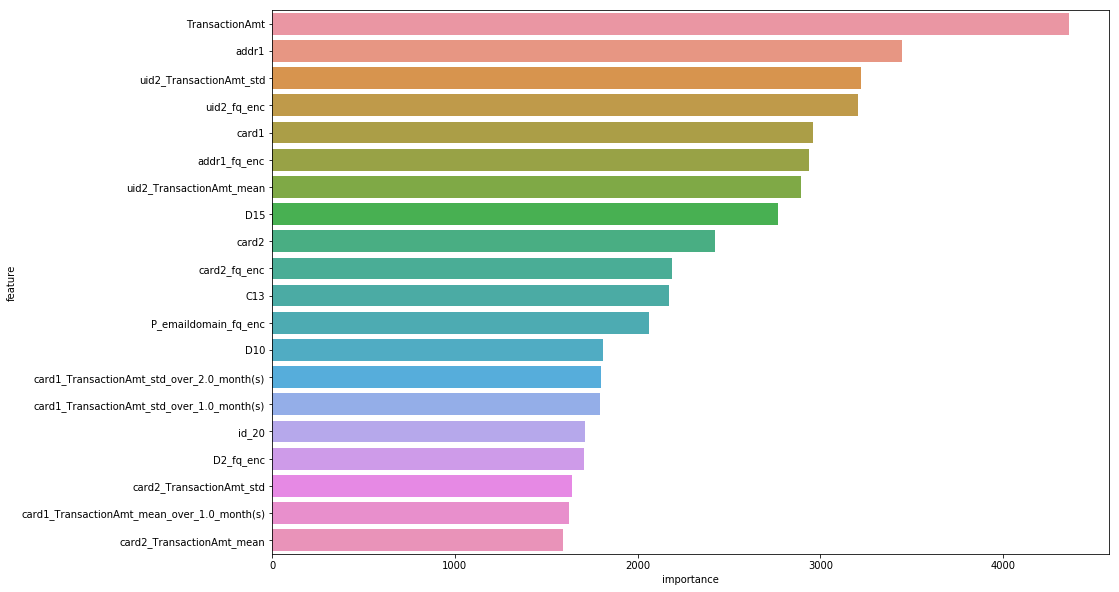

In [161]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))

In [162]:
feature_importance_df

,feature,importance
0,TransactionAmt,4363
1,addr1,3448
2,uid2_TransactionAmt_std,3222
3,uid2_fq_enc,3205
4,card1,2961
5,addr1_fq_enc,2937
6,uid2_TransactionAmt_mean,2893
7,D15,2771
8,card2,2422
9,card2_fq_enc,2189
